In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
from example_package import model, training, datasets, metrics
from tqdm import tqdm
from scipy.stats import bootstrap
%load_ext autoreload
%autoreload 2

In [2]:
def VisualizeReconstruction(original, reconstructed):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Original Data")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Reconstructed Data")
    plt.axis('off')

    plt.show()

In [3]:
n_visible = 4
n_hidden = 2
dataset = datasets.BasicEncoderDataset(n_visible).data[:]

In [4]:
#model paramss
bias = True
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
train_params = {
    'double_clamped':False, #bad, do not use
    'discretize_gradients':True
}

In [ ]:
#control variable 
epochs_all = [500]
#statistics
n_repetitions = 10
data = np.zeros((len(epochs_all),n_repetitions))
for i,control in tqdm(enumerate(epochs_all)):
    for j in tqdm(range(n_repetitions)):
        epochs = control
        # Make an object from the model and train it
        model_B = model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
        training.TrainBatch(model_B,dataset, epochs, learning_rate,noise_levels,steps_statistics,annealing_scheme,
                            train_params,tqdm=False)
        vector_s1, vectors_2 = metrics.get_encoding_vectors(model_B)
        hamming_data = metrics.hamming_distance(np.sign(vector_s1).T)
        data_point = hamming_data[2]
        data[i,j] = data_point


0it [00:00, ?it/s]

In [ ]:
# data_o = data
# x_o = epochs_all
data_spliced = np.concat(data_o,data)
x_spliced = np.concat(x_o,data)

In [ ]:
def mean_statistic(data, axis=1):
    return np.mean(data, axis=axis)

In [58]:
print(data.shape)
means_bs = bootstrap((data,), mean_statistic,axis=1)#, n_resamples=1000, vectorized=True, axis=0)
ci_lower,ci_upper = means_bs.confidence_interval

(4, 10)


In [59]:
y_lims = (0,1)


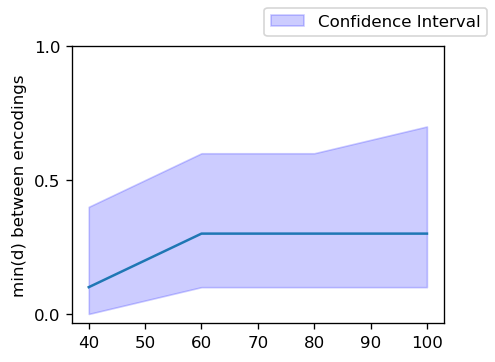

In [60]:
fig, ax = plt.subplots(figsize=(4,3),dpi=120)
ax.plot(epochs_all,np.mean(data,1))
ax.fill_between(epochs_all, ci_lower, ci_upper, color='blue', alpha=0.2, label='Confidence Interval')
ax.set_ylabel('min(d) between encodings')
ax.set_yticks(np.linspace(*y_lims,3))
fig.legend()
plt.show()